<font size="5">Importing Libraries</font>

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

<font size="5">Constants for preprocessing</font>

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

DATA_DIR = 'brain-tumor-dataset'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')

<font size="5">Load Dataset</font>

The dataset consists of 3064 brain mri images consisting of original images and masks

In [4]:
print("Loading and preprocessing data...")
image_files = sorted(os.listdir(IMAGES_DIR))
mask_files = sorted(os.listdir(MASKS_DIR))

print(f"Total number of images: {len(image_files)}")
print(f"Total number of masks: {len(mask_files)}")

X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.int32)

for idx, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
    img_path = os.path.join(IMAGES_DIR, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X[idx] = img / 255.0
    
    mask_path = os.path.join(MASKS_DIR, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask > 0, axis=-1)
    y[idx] = mask

Loading and preprocessing data...
Total number of images: 3064
Total number of masks: 3064


<font size="5">Visualizing the Sample Images</font>

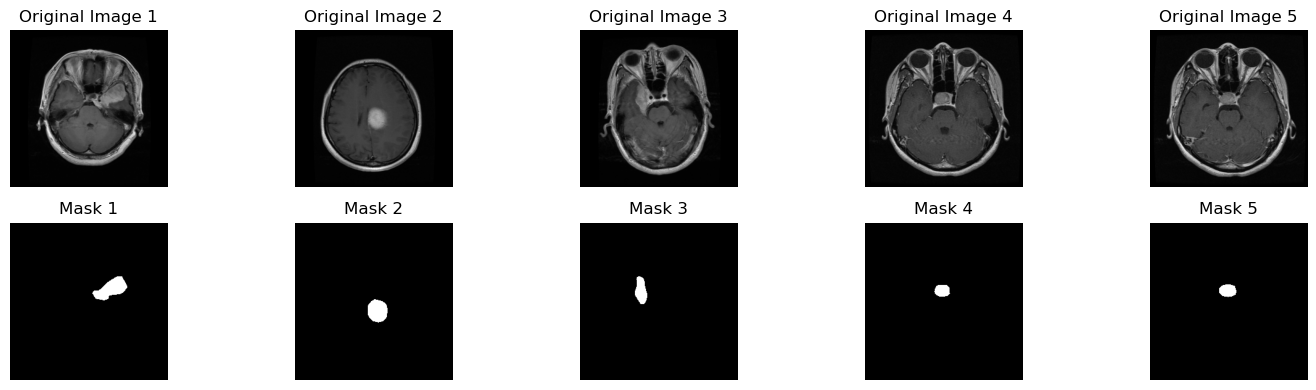

In [5]:
plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

<font size="5">Analyzing Tumor Sizes</font>

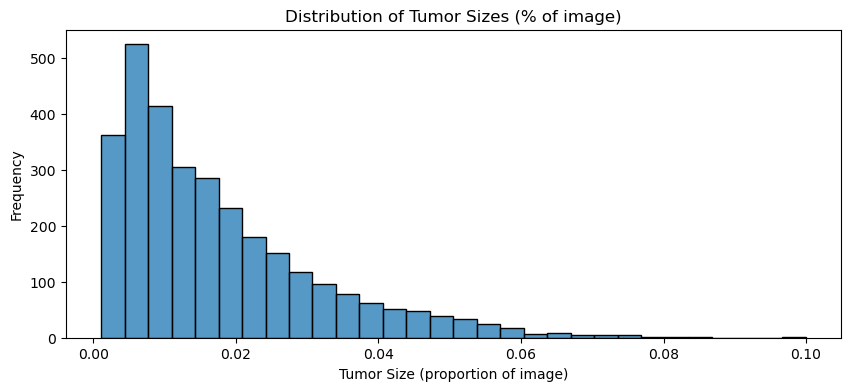

Average tumor size: 1.75% of image
Median tumor size: 1.34% of image
Max tumor size: 9.99% of image
Min tumor size: 0.11% of image


In [6]:
tumor_sizes = [np.sum(mask) / (IMG_WIDTH * IMG_HEIGHT) for mask in y]

plt.figure(figsize=(10, 4))
sns.histplot(tumor_sizes, bins=30)
plt.title('Distribution of Tumor Sizes (% of image)')
plt.xlabel('Tumor Size (proportion of image)')
plt.ylabel('Frequency')
plt.show()

print(f"Average tumor size: {np.mean(tumor_sizes):.2%} of image")
print(f"Median tumor size: {np.median(tumor_sizes):.2%} of image")
print(f"Max tumor size: {np.max(tumor_sizes):.2%} of image")
print(f"Min tumor size: {np.min(tumor_sizes):.2%} of image")

<font size="5">Splitting Dataset into Test and Train</font>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 2451
Testing set size: 613


<font size="5">Creating the unet model</font>

In [ ]:
input_layer = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encoder
# Level 1
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Level 2
c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

# Level 3
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
c3 = Dropout(0.3)(c3)
p3 = MaxPooling2D((2, 2))(c3)

# Level 4
c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
c4 = Dropout(0.3)(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bridge
c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
c5 = Dropout(0.5)(c5)

# Decoder
# Level 4
u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u4 = concatenate([u4, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
c6 = Dropout(0.3)(c6)

# Level 3
u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u3 = concatenate([u3, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
c7 = Dropout(0.3)(c7)

# Level 2
u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u2 = concatenate([u2, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

# Level 1
u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u1 = concatenate([u1, c1])
c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

outputs = Conv2D(1, 1, activation='sigmoid')(c9)

model = Model(inputs=[input_layer], outputs=[outputs])

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]  

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

<font size="5">Compile and Train Model</font>

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50


c:\Users\Aashish\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9813 - loss: 0.1906 - mean_io_u: 0.4908 - val_accuracy: 0.9832 - val_loss: 0.0637 - val_mean_io_u: 0.4916
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9819 - loss: 0.0665 - mean_io_u: 0.4909 - val_accuracy: 0.9832 - val_loss: 0.0601 - val_mean_io_u: 0.4916
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9819 - loss: 0.0582 - mean_io_u: 0.4909 - val_accuracy: 0.9832 - val_loss: 0.0532 - val_mean_io_u: 0.4916
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9823 - loss: 0.0513 - mean_io_u: 0.4911 - val_accuracy: 0.9844 - val_loss: 0.0466 - val_mean_io_u: 0.4916
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9839 - loss: 0.0487 - mean_io_u: 0.4910 - val_accuracy: 0.9883 - val_loss: 0.0364 - val_mean_io_u: 0.4916
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9869 - loss: 0.0377 - mean_io_u: 0.4913 - val_accuracy: 0.9884 - val_loss: 0.03

<font size="5">Plotting training history</font>

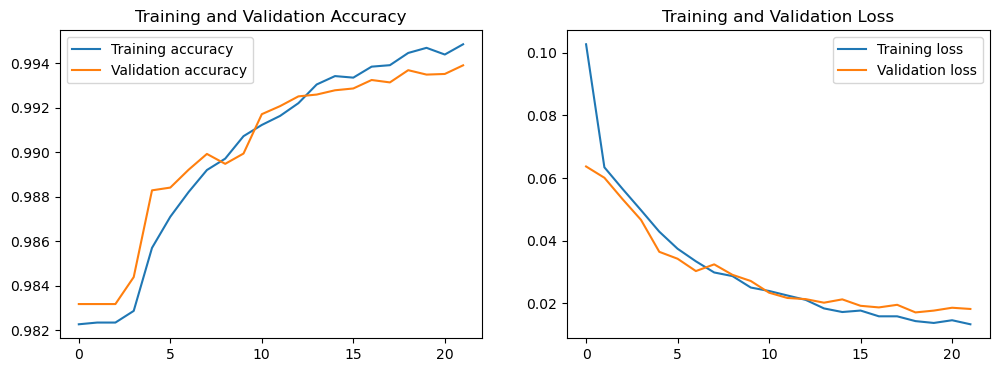

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<font size="5">Visualizing Predictions</font>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


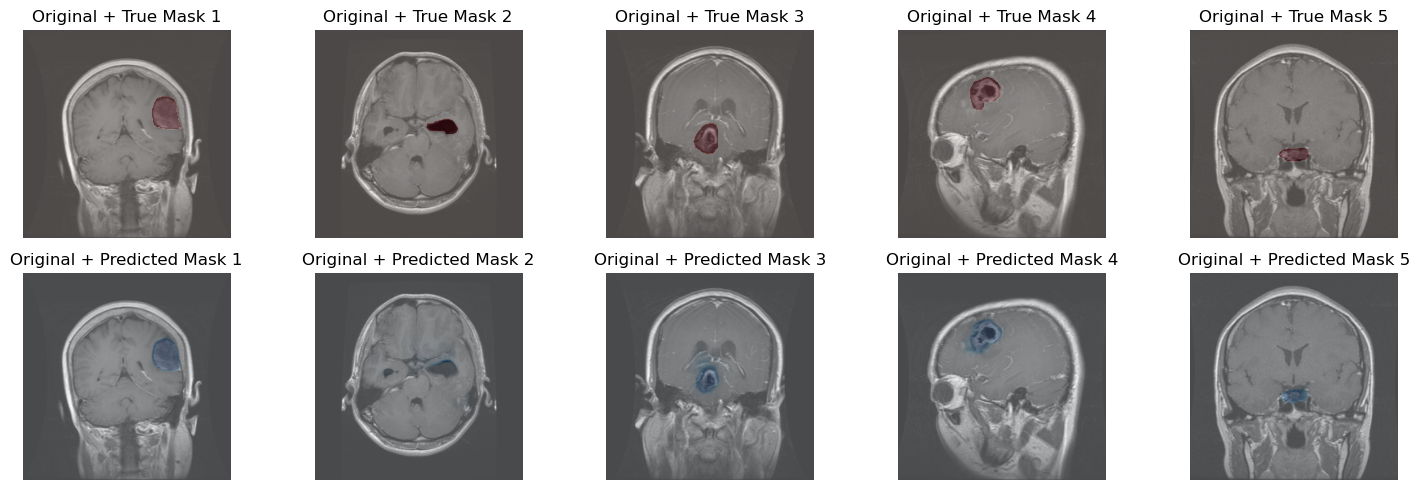

In [12]:
num_samples = 5

predictions = model.predict(X_test[:num_samples])

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    # Original image with true mask overlay
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(X_test[i])
    plt.imshow(y_test[i].squeeze(), alpha=0.3, cmap='Reds')
    plt.title(f'Original + True Mask {i+1}')
    plt.axis('off')
    
    # Original image with predicted mask overlay
    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.imshow(X_test[i])
    plt.imshow(predictions[i].squeeze(), alpha=0.3, cmap='Blues')
    plt.title(f'Original + Predicted Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Evaluate model

In [13]:
test_results = model.evaluate(X_test, y_test, verbose=1)
print("\nTest Set Metrics:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"{metric_name}: {value:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 832ms/step - accuracy: 0.9936 - loss: 0.0170 - mean_io_u: 0.4924

Test Set Metrics:
loss: 0.0171
compile_metrics: 0.9937


In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = model.predict(X_test)

# Flatten and threshold predictions
y_true_flat = y_test.flatten()
y_pred_flat = (y_pred > 0.5).flatten()

# Calculate metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)

# Calculate Dice coefficient
intersection = np.sum(y_true_flat * y_pred_flat)
dice = (2. * intersection + 1e-7) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-7)

print("\nSegmentation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step

Segmentation Metrics:
Precision: 0.8350
Recall: 0.7781
Dice Coefficient: 0.8056


Confusion Matrix

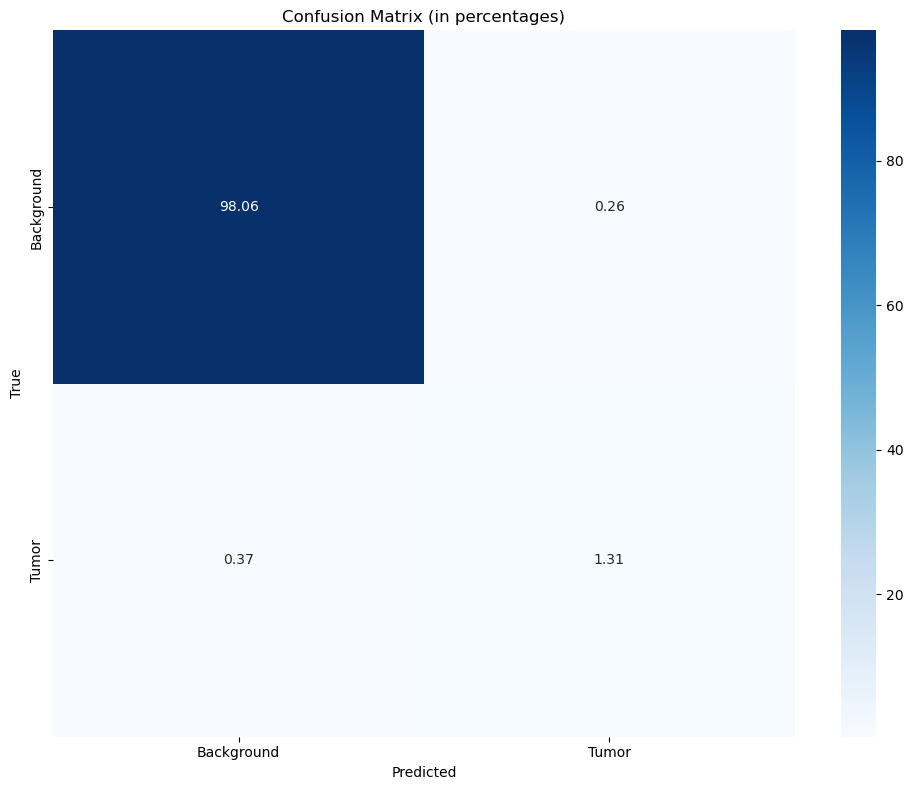

In [21]:
cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_percentage = (cm / np.sum(cm)) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f',
            xticklabels=['Background', 'Tumor'],
            yticklabels=['Background', 'Tumor'],
            cmap='Blues')

plt.title('Confusion Matrix (in percentages)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()